In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [48]:
########################################
# 1. Load all saved embeddings
########################################

embeddings_dir = "embeddings"
# embeddings_dir = '_embeddings'
# embeddings_dir = 'emb_16_with_negation_embeddings'
# embeddings_dir = 'emb_16_featurethenlabel_embeddings'
# embeddings_dir = 'emb_16_featurethenlabel1_embeddings'
embedding_files = sorted(
    [f for f in os.listdir(embeddings_dir) if f.endswith(".npy")],
    key=lambda x: int(x.split("_")[1])  # Assumes filenames like "epoch_1_embeddings.npy"
)
# e.g., ["epoch_1_embeddings.npy", "epoch_2_embeddings.npy", ...]

# Read each epoch's embeddings into a list
embeddings_list = []
for ef in embedding_files:
    epoch_embeddings = np.load(os.path.join(embeddings_dir, ef))  # shape: [vocab_size, embedding_dim]
    embeddings_list.append(epoch_embeddings)

num_epochs = len(embeddings_list)
vocab_size, embedding_dim = embeddings_list[0].shape

In [49]:
label_list = ['Goldfish', 'Tuna', 'Robin', 'Canary',
              'Rose', 'Daisy', 'Pine', 'Oak']
feature_list = ['can_grow',
                'is_mammal',
                'has_leaves',
                'can_move',
                'has_trunk',
                'can_fly',
                'can_swim',
                'has_stem',
                'is_warmblooded',
                'can_flower']

In [50]:
tiny_vocab={'[PAD]': 0, '[UNK]': 1, 'can_grow': 2, 'is_mammal': 3, 'has_leaves': 4, 'can_move': 5, 'has_trunk': 6, 'can_fly': 7, 'can_swim': 8, 'has_stem': 9, 'is_warmblooded': 10, 'can_flower': 11, 'Goldfish': 12, 'Tuna': 13, 'Robin': 14, 'Canary': 15, 'Rose': 16, 'Daisy': 17, 'Pine': 18, 'Oak': 19}
if 'negation' in embeddings_dir:
    tiny_vocab = {x:i for i,x in enumerate(['[PAD]','[UNK]', 'NOT']+feature_list+label_list)}

id_to_token = {v: k for k, v in tiny_vocab.items()}
tokens_to_keep = label_list
# tokens_to_keep = tiny_vocab.keys()
indices_to_keep = [tiny_vocab[t] for t in tokens_to_keep if t in tiny_vocab]

In [51]:
filtered_embeddings_list = []
for epoch_embeddings in embeddings_list:
    # shape: [vocab_size, embedding_dim]
    # filter to shape: [len(indices_to_keep), embedding_dim]
    filtered_epoch_emb = epoch_embeddings[indices_to_keep, :]
    filtered_embeddings_list.append(filtered_epoch_emb)

# Now combine them all for MDS
# shape: [num_epochs * len(indices_to_keep), embedding_dim]
all_embeddings = np.concatenate(filtered_embeddings_list, axis=0)

In [52]:
embeddings_list[0][0].shape

(32,)

In [53]:
num_epochs

2059

In [54]:
old_num_epochs= num_epochs

In [55]:
all_embeddings.shape

(16472, 32)

In [56]:
sampling_every = 10

In [57]:
all_embeddings = np.concatenate([
    all_embeddings[epoch_idx * (all_embeddings.shape[0] // num_epochs) : (epoch_idx + 1) * (all_embeddings.shape[0] // num_epochs)]
    for epoch_idx in range(0, num_epochs, sampling_every)
], axis=0)

In [58]:
num_epochs = len(range(0, num_epochs, sampling_every))

In [59]:
########################################
# 2. Combine them for a single MDS
########################################

# Stack into shape [num_epochs * vocab_size, embedding_dim]
# all_embeddings = np.concatenate(embeddings_list, axis=0)

# Create and fit MDS to reduce to 2D
mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
all_embeddings_2d = mds.fit_transform(all_embeddings)  # shape: [num_epochs*vocab_size, 2]


# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# all_embeddings_2d = pca.fit_transform(all_embeddings)



########################################
# 3. Plot each epoch in 2D
########################################

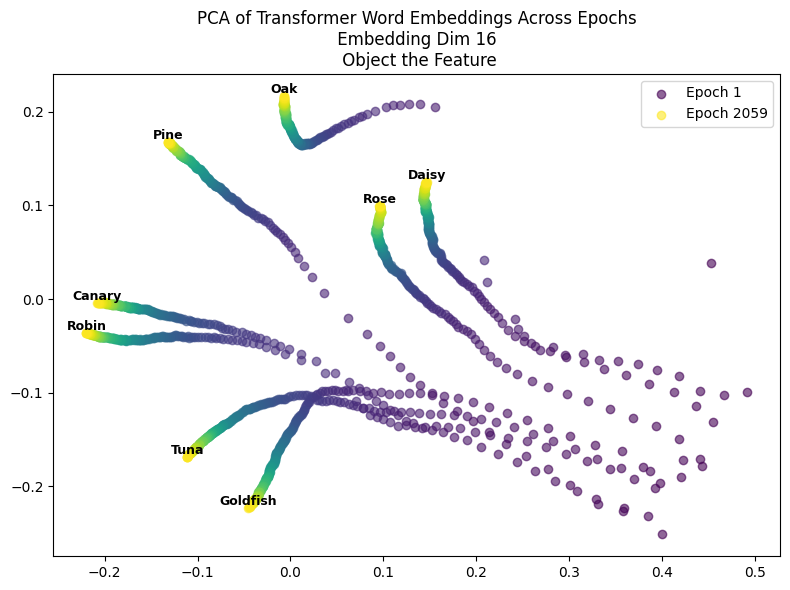

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))

# We'll use a colormap (viridis) for distinct epoch colors
colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

for epoch_idx in range(num_epochs):
    start = epoch_idx * len(indices_to_keep)
    end   = (epoch_idx + 1) * len(indices_to_keep)
    coords_2d = all_embeddings_2d[start:end]

    
    if epoch_idx==0 :
        
        ax.scatter(
            coords_2d[:, 0],
            coords_2d[:, 1],
            color=colors[epoch_idx],
            alpha=0.6,
            label=f"Epoch {epoch_idx + 1}"
        ) 
    elif  epoch_idx ==num_epochs-1:
           ax.scatter(
            coords_2d[:, 0],
            coords_2d[:, 1],
            color=colors[epoch_idx],
            alpha=0.6,
            label=f"Epoch {old_num_epochs}"
        )       
    else:
        ax.scatter(
            coords_2d[:, 0],
            coords_2d[:, 1],
            color=colors[epoch_idx],
            alpha=0.6
            # label=f"Epoch {epoch_idx + 1}"
        )


########################################
# 4. Label each word at its final position
########################################

final_start = (num_epochs - 1) * len(indices_to_keep)
final_end   = num_epochs * len(indices_to_keep)
final_coords_2d = all_embeddings_2d[final_start:final_end]

# We'll place text for the final positions
for i, token_id in enumerate(indices_to_keep):
    x, y = final_coords_2d[i]
    token_str = id_to_token[token_id]
    ax.text(x, y, token_str, fontsize=9, fontweight="bold", ha="center", va="bottom")

ax.set_title("MDS of Transformer Word Embeddings Across Epochs\n Embedding Dim 16 \n Feature then object")
ax.set_title("PCA of Transformer Word Embeddings Across Epochs\n Embedding Dim 16 \n With Negation")
ax.set_title("PCA of Transformer Word Embeddings Across Epochs\n Embedding Dim 16 \n Object the Feature")

ax.legend()
plt.tight_layout()
plt.savefig(embeddings_dir+'.png')
plt.show()